# Process a single image

This notebook processes a single image. The function `process_image` is meant to be called over and over by client to process an entire collection of images.

* Removing the "background" color
* Generating a quantized palette
* Creating quantized copy



## Import dependencies

In [1]:
# This is a trick to import from parent directories in Jupyter Notebooks
import os
import sys
from PIL import Image
import json
    
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import margo_loader
from utils.ImageFiles import read_img, write_img
from background_deletion.LightnessPixelFilter import LightnessPixelFilter
from color_extraction.MMCQExtractor import MMCQExtractor as Extractor

## Define process_image() function

In [2]:
def save_result(name, result, dir_path):
    
    # Save the processed images
    for subdir in ["no_background", "quantized"]:
        subdir_path = os.path.join(dir_path, subdir)

        if not os.path.exists(subdir_path):
            os.makedirs(subdir_path)
            
        write_img(result[subdir], os.path.join(subdir_path, f"{subdir}-{name}.png"))
        
    # Make JSON dir if it doesn't exist
    palette_dir = os.path.join(dir_path, "palette")
    if not os.path.exists(palette_dir):
        os.makedirs(palette_dir)
        
    # Write the palette JSON file
    open(os.path.join(palette_dir, f"palette-{name}.json"),"w").write(json.dumps(result["palette"].to_dict()))
        
        

In [3]:
def process_image(image_path, save_to_dir=None, scale=1):
    
    
    # Skip images we've already processed
    
    if save_to_dir is not None:
        name = os.path.basename(image_path)
        palette_dir = os.path.join(save_to_dir, "palette")
        palette_path = os.path.join(palette_dir, f"palette-{name}.json")
        if os.path.exists(palette_path):
            print(f"Skipping image: {image_path}")
            return
    
    print(f"Processing image: {image_path}")
                 
    img = read_img(image_path, scale=scale)
    
    lightness_filter = LightnessPixelFilter(0, 200)
    
    # remove the background
    nbg = lightness_filter.filter_image(img)
    
    # quantize the pixels
    extractor = Extractor(nbg)
    quantized = extractor.get_color_map()
    palette = extractor.get_palette()
    
    ret = {
        "no_background":nbg,
        "original":img,
        "palette":palette,
        "quantized":quantized
    }
    
    if save_to_dir is not None:
        save_result(name, ret, save_to_dir)
    
    return ret


## Demo

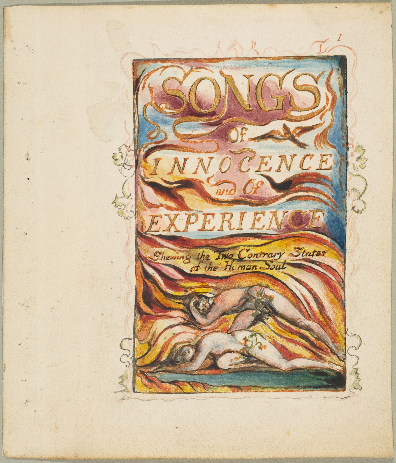

In [4]:
# :: ignore-cell ::

"""
Here's the unedited image, scaled down 50% to speed  up this demo
"""
from PIL import Image

image = read_img("../images/sample.jpg", scale=0.125)
Image.fromarray(image)

In [5]:
# :: ignore-cell ::

"""
Here's the image after removing the background and quantizing
"""

result = process_image("../images/sample.jpg", scale=0.125, save_to_dir="../out/sample")


Processing image: ../images/sample.jpg


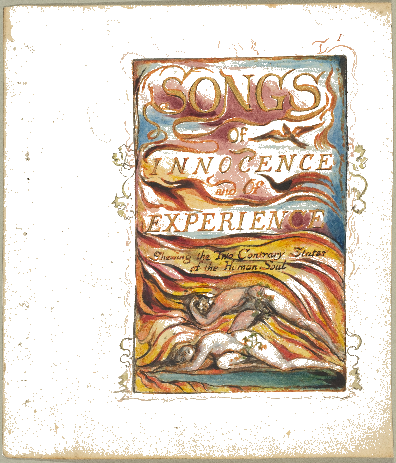

In [6]:
# :: ignore-cell ::

"""
Here's the image after subtracting the background, but without any quantization
"""

Image.fromarray(result["no_background"])

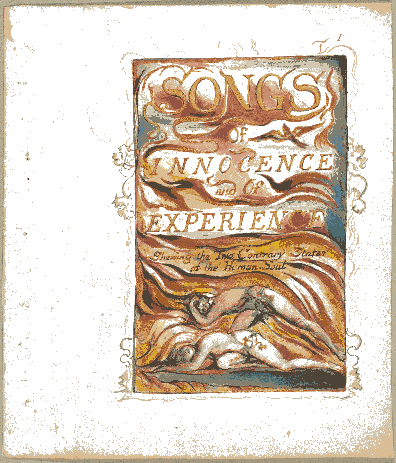

In [7]:
# :: ignore-cell ::

"""
Here's the image after subtracting the background and quantizing
"""
Image.fromarray(result["quantized"])

In [8]:
# :: ignore-cell ::

"""
Here's the resulting palette
"""
result["palette"].to_dict()

{'rgb(244,189,136)': 179,
 'rgb(232,212,156)': 339,
 'rgb(211,160,133)': 1874,
 'rgb(99,132,122)': 90,
 'rgb(78,108,112)': 869,
 'rgb(216,171,100)': 2878,
 'rgb(221,174,37)': 587,
 'rgb(183,175,149)': 4467,
 'rgb(92,129,150)': 382,
 'rgb(200,141,109)': 2779,
 'rgb(164,153,127)': 5023,
 'rgb(219,189,149)': 12240,
 'rgb(205,151,75)': 5420,
 'rgb(183,113,78)': 6687,
 'rgb(78,67,55)': 6500,
 'rgb(210,200,177)': 9438,
 'rgb(132,128,111)': 6614,
 'rgb(162,95,44)': 5915,
 'rgb(146,83,67)': 4740}